# LeNet5
[Gradient-Based Learning Applied to Document Recognition](https://d1wqtxts1xzle7.cloudfront.net/61181394/Gradient_Based_Learning_Lecun20191110-2628-k1dtd1.pdf?1573449385=&response-content-disposition=inline%3B+filename%3DGradient_Based_Learning_Lecun.pdf&Expires=1609063666&Signature=cvOPVDwciyy28Kx718WuwMBl~s-PJDH6AXdTEzkW0K1npnWoTsYkXbAWFM4aj5ppegmBEyk5kFaDgjGUQwh2ax7EYPPuYF0-KTIQiaKagbpRa46eprf2OkUXLeVUPefRuYYPUk8qs-86E-VgJ2YTqnFI5VwKE5NdOd9MDmR-IGwftxsRoLg6GbYhsMMOyRfluBC9hTu2eQC8svtqC~8HvxHn1aUQO6URXAqc-6BAAYVrfH94wRSW6DvUmZYicFMtlBzp6mojBIXUHNLzjQgvboa-PxX76-5p3BeMnXzBh38YwF5qTb-W39XICSe4fH1wNSVAhzj~LH3zSxZ0azyfCw__&Key-Pair-Id=APKAJLOHF5GGSLRBV4ZA)
- 

## 요약
- Convoultional Layer 2개
- Fully-connected Layer 3개
- Average Pooling Layer 2개
- Activation Function(활성화 함수) : Tanh
- 출력값 Softmax 사용
- 데이터 6만개(MNIST)
- Cost Function(손실함수) : Cross-Entropy

In [226]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

### Datasets

In [227]:
transform = transforms.Compose([transforms.Resize((32,32)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5], std=[0.5])])

train_dataset = datasets.MNIST(root='../../data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='../../data', train=False, download=True, transform=transform)

train_dataset, val_dataset = random_split(train_dataset, (55000, 5000))

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

### Visualization

In [228]:
def show_image(x, y, y_pred=None):
    
    x = x[:9, 0, ...]
    y = y[:9]
    
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        
        ax.imshow(x[i], cmap='gray')
        
        if y_pred is None:
            xlabel = "True: {}".format(y[i])
        else:
            xlabel = "True: {}, Pred: {}".format(y[i], y_pred[i])
            
        ax.set_xlabel(xlabel)
        
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

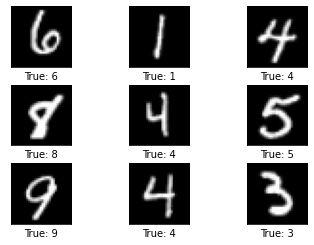

In [229]:
images, labels = iter(train_loader).next()
show_image(images, labels)

### Model

In [230]:
class Lenet5(nn.Module):
    
    def __init__(self):
        super(Lenet5, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        self.maxpool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
       
        x = torch.tanh(self.conv1(x))
        
        x = self.maxpool(x)
        
        x = torch.tanh(self.conv2(x))
        x = self.maxpool(x)
        
        x = x.view(-1, 16*5*5)
        
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        
        return x
                

In [231]:
model = Lenet5()
model

Lenet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

### Optimizer & Loss Function

In [232]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

### Cuda

In [233]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


### Training

In [234]:
EPOCH = 20
train_loss_list, val_loss_list = [], []

for e in range(EPOCH):
    
    train_loss = 0
    train_correct = 0
    
    model.to(device)
    model.train()
    
    for i, data in enumerate(train_loader):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        output = model(images)
        
        loss = loss_func(output, labels)
        
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.cpu().item()
        
        pred = output.argmax(1)
        train_correct += (pred == labels).cpu().sum().item()
        
    train_acc = train_correct / len(train_dataset)
    train_loss = train_loss / len(train_dataset)
    train_loss_list.append(train_loss)
    
    val_loss = 0
    val_correct = 0
    
    model.eval()
    
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            
            output = model(images)
            
            loss = loss_func(output, labels)
            
            val_loss += loss.cpu().item()
            
            val_pred = output.argmax(1)
            val_correct += (val_pred == labels).cpu().sum().item()
            
        val_acc = val_correct / len(val_dataset)
        val_loss = val_loss / len(val_dataset)
        val_loss_list.append(val_loss)
    
    info = '[EPOCH {}/{}] : train-loss = {:0.4f} | train-acc = {:0.4f} | val-loss = {:0.4f} | val-acc = {:0.4f}'
    print(info.format(e+1, EPOCH, train_loss, train_acc, val_loss, val_acc))
    
    torch.save(model.state_dict(), '../../data/weight')

[EPOCH 1/20] : train-loss = 0.1360 | train-acc = 0.4093 | val-loss = 0.1187 | val-acc = 0.6798
[EPOCH 2/20] : train-loss = 0.1021 | train-acc = 0.7702 | val-loss = 0.0911 | val-acc = 0.8190
[EPOCH 3/20] : train-loss = 0.0847 | train-acc = 0.8347 | val-loss = 0.0800 | val-acc = 0.8588
[EPOCH 4/20] : train-loss = 0.0768 | train-acc = 0.8653 | val-loss = 0.0743 | val-acc = 0.8800
[EPOCH 5/20] : train-loss = 0.0723 | train-acc = 0.8831 | val-loss = 0.0706 | val-acc = 0.8918
[EPOCH 6/20] : train-loss = 0.0692 | train-acc = 0.8953 | val-loss = 0.0680 | val-acc = 0.9036
[EPOCH 7/20] : train-loss = 0.0669 | train-acc = 0.9069 | val-loss = 0.0660 | val-acc = 0.9124
[EPOCH 8/20] : train-loss = 0.0650 | train-acc = 0.9163 | val-loss = 0.0642 | val-acc = 0.9210
[EPOCH 9/20] : train-loss = 0.0634 | train-acc = 0.9234 | val-loss = 0.0628 | val-acc = 0.9256
[EPOCH 10/20] : train-loss = 0.0621 | train-acc = 0.9291 | val-loss = 0.0617 | val-acc = 0.9298
[EPOCH 11/20] : train-loss = 0.0610 | train-acc =

### Test

Accuracy of Test Data : 96.07%


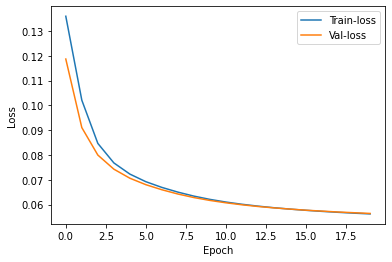

In [266]:
model.cpu()
model.eval()

test_correct = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data

        prediction = model(images)
        
        test_correct += (prediction.argmax(1) == labels).sum().item()
        
    
    test_acc = test_correct / len(test_dataset)
    print('Accuracy of Test Data : %0.2f%%' %(test_acc*100))

plt.plot(train_loss_list)
plt.plot(val_loss_list)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train-loss', 'Val-loss'])

plt.show()